In [1]:
import matplotlib.pyplot as plt
from welly import Well
import numpy as np

In [35]:
well = Well.from_las('C:/Users/jonak/OneDrive - University of Calgary/Desktop/Rockyview_Geoservices/Synthetic Generation Program/Sample Dataset/100053405624W400.las')
well.data.keys()
print(well)

Well(uwi: '100053405624W400', name: 'KETCH FBA 5-34-56-24', 18 curves: ['ILM', 'IMPH', 'CAL2', 'NPOR', 'IDPH', 'SFLU', 'DRHO', 'DPHI', 'SP', 'SFLA', 'DT_COMP', 'RHOB', 'DT', 'GR', 'PEF', 'ILD', 'CALI', 'CIDP'])


C:\ProgramData\Anaconda3\lib\site-packages\welly\las.py:163: UserWarning: Section was not recognized and not parsed: Tops
  datasets = from_las_2_or_older(las)


In [85]:
#loading log files
KB = well.location.ekb # Kelly bushing 
SON_name = 'DT' #sonic variable picked
STEP = well.data[SON_name].step # depth step = dz
DEPTH = well.data[SON_name].basis # depth reference of the well 
DT = well.data[SON_name]
print(DT.values)
print(DT*2*STEP/10**6)
print(KB)

[nan nan nan ... nan nan nan]
Curve(mnemonic=DT, units=US/M, start=150.8760, stop=1507.9980, step=0.1524, count=[6477])
704.3


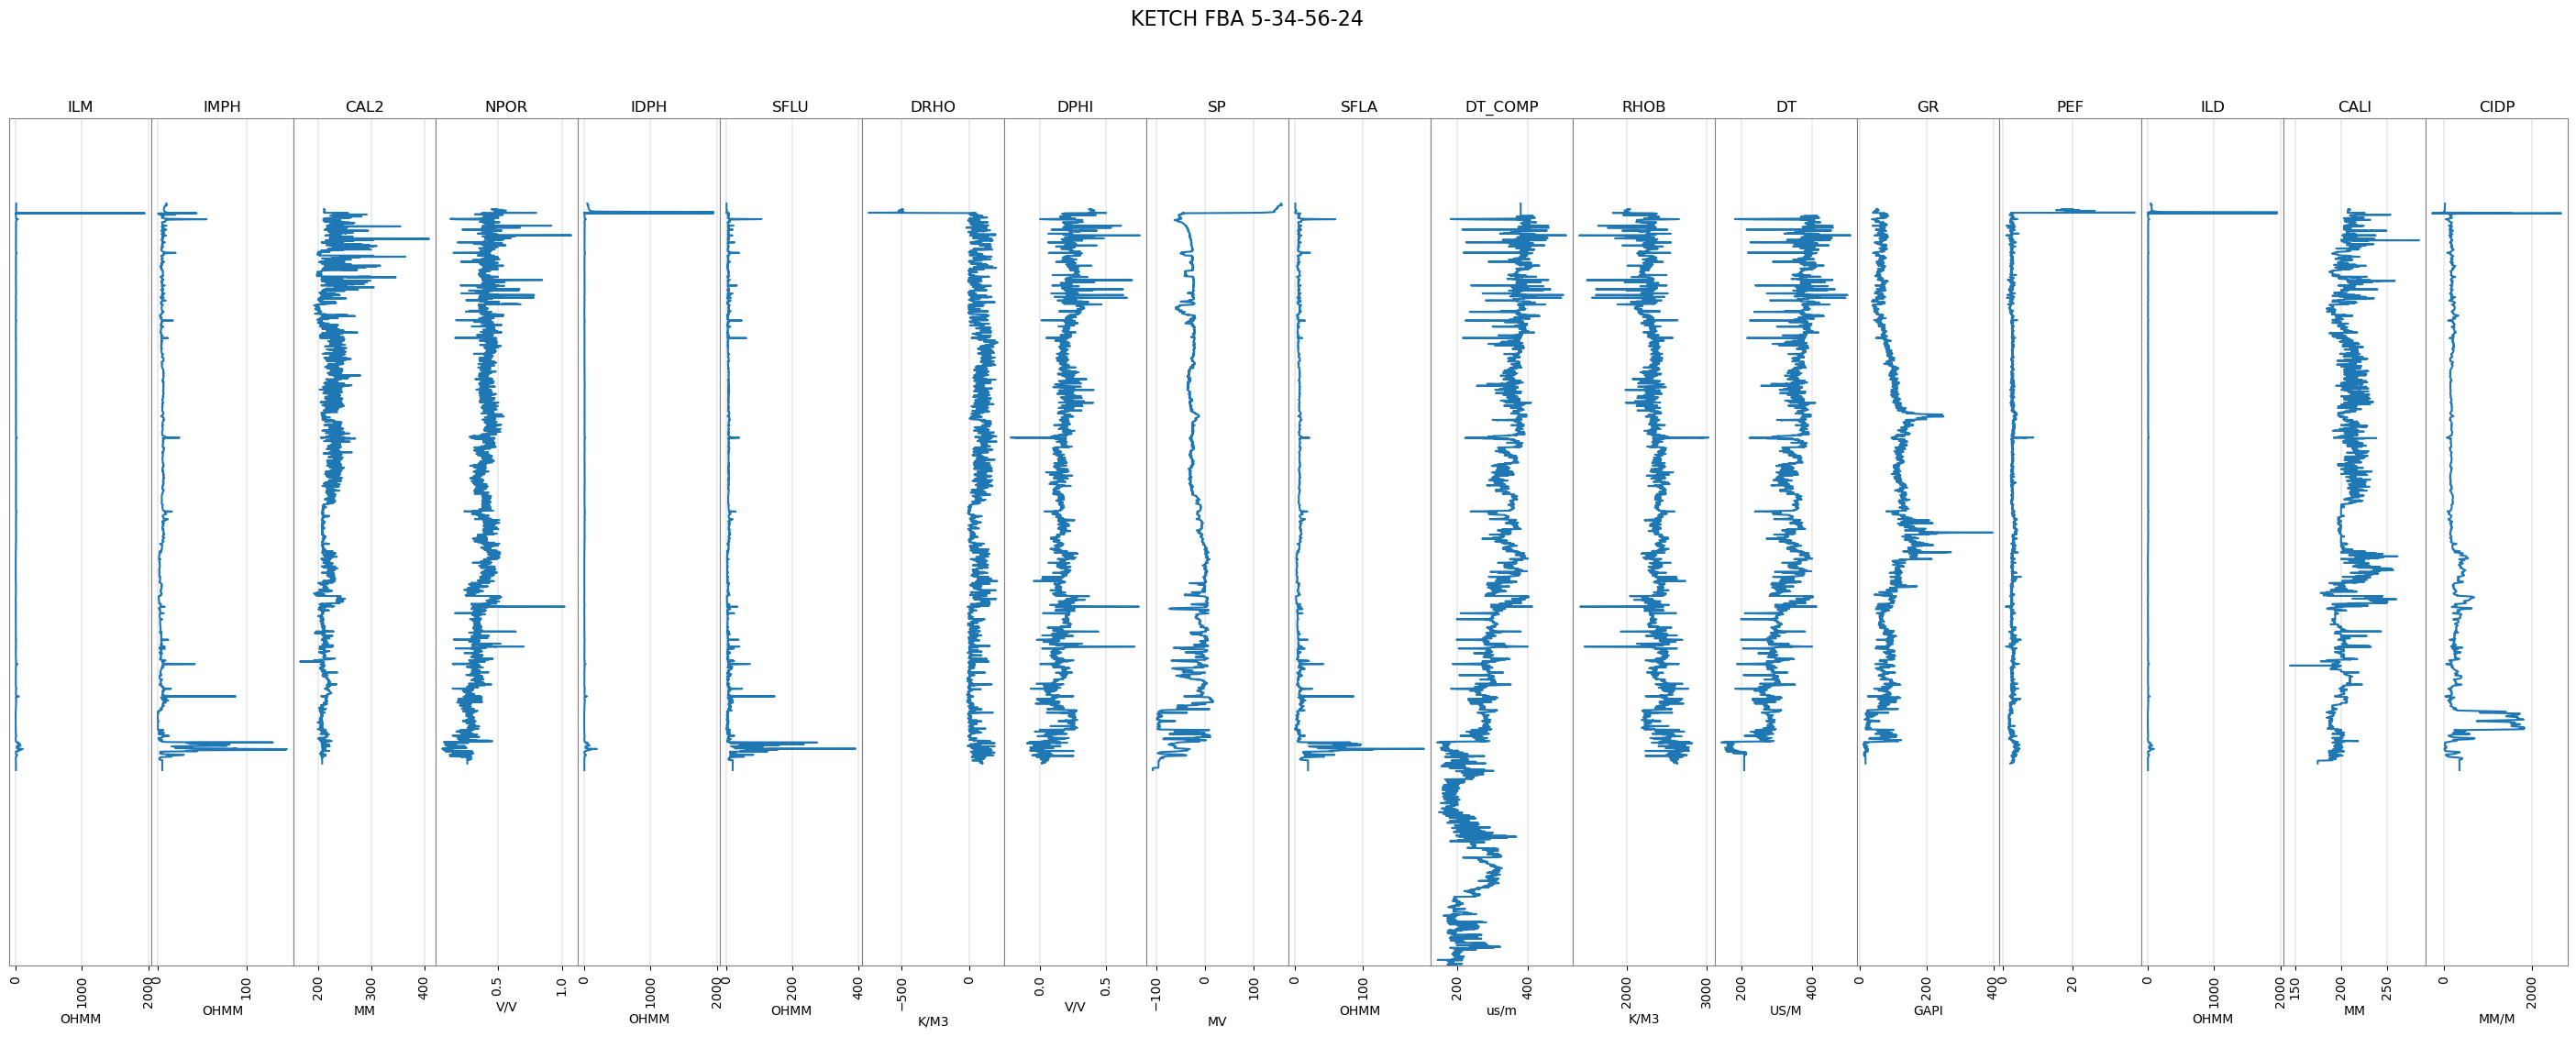

In [13]:
well.plot()

Text(0, 0.5, 'depth')

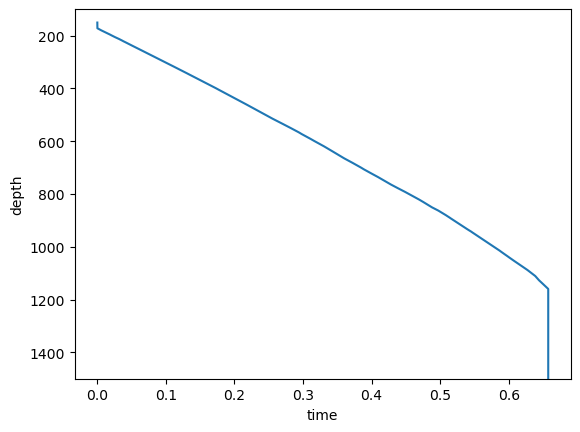

In [81]:
# Time depth relationship = calculating time to each depth point and step 
DT_iterval = np.nan_to_num(DT.values)*2*STEP/10**6 # 2* us/m * dz / 10^6us/s = calculating time between each step, multiply by 2 and take the cumulative sum 
t_cum = np.cumsum(DT_iterval) # determining the cumulative sum of the travel time between each layer 
plt.plot(t_cum,DEPTH) # time depth relationship of data 
plt.ylim(1500,100)
plt.xlabel('time (s)')
plt.ylabel('depth (m)')

0.24657600000000005


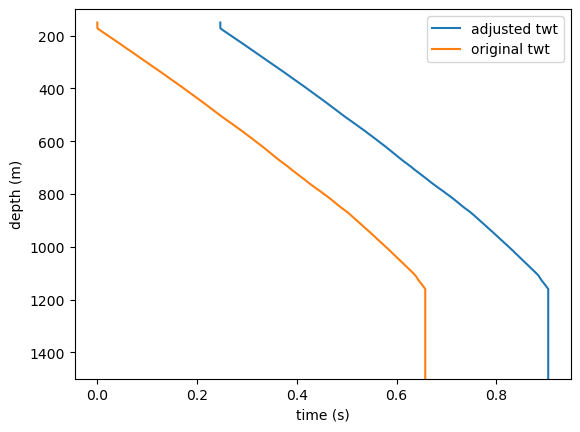

In [96]:
# calculating the distance below seismic datum: 
"""
this will be added to the t_cumulative time
"""
# log start depth - from well data 
# Kelly bushing - from well data 
# seismic datum - (maybe retreive from seismic datum?)
dlog_start = well.data[SON_name].start #m
KB = well.location.ekb #m
seis_dat = 800 
dblwseisdat = seis_dat-KB+dlog_start # distance below seismic datum 

#question: do we need to adjust the 

# calculating log start time -> used for bulk shifting 
repl_vel = 2000 # m/s - replacement velocity 
log_start_time = (dblwseisdat/repl_vel)*2 

print(log_start_time)

# Bulk shift for data - 
TWT = t_cum+log_start_time
plt.plot(TWT,DEPTH,label="adjusted twt") # time depth relationship of data 
plt.plot(t_cum,DEPTH,label="original twt") # time depth relationship of data 
plt.ylim(1500,100)
plt.xlabel('time (s)')
plt.ylabel('depth (m)')
plt.legend()

In [92]:
# creating a time depth pair 
"""
maybe have this as user defined? 
create a dialog box with loop to add time-depth pair 
1. have lines to define subsurface location 'ss' and time 't'
2. have the ability to add multiple stretch and squeeze with a press of a button 
3. save the data time depth pair back to the main program 
4. when window is reopened, ensure that the previous data is loaded when 
"""
timedepth = {'ss':[45.1,-65.3,-172.5,-290],'t':[0.605,0.687,0.759,0.834]} # ss = subsurface depth; t = time 

mlst = [] # calculating the depth below the reference time 
for value in timedepth['ss']:
    mlst.append(KB-value)

timedepth['d'] = mlst
timedepth

{'ss': [45.1, -65.3, -172.5, -290],
 't': [0.605, 0.687, 0.759, 0.834],
 'd': [659.1999999999999, 769.5999999999999, 876.8, 994.3]}

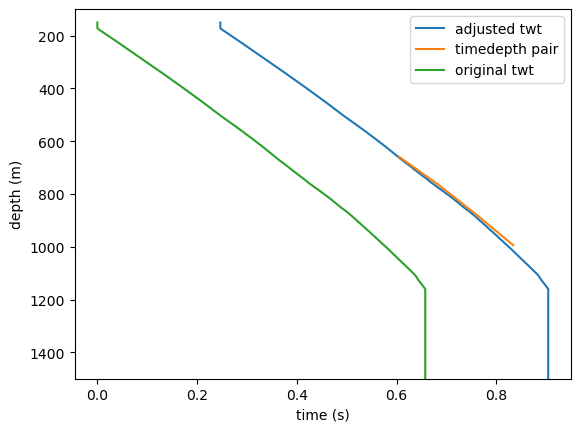

In [97]:
#plotting and determining 
plt.plot(TWT,DEPTH,label="adjusted twt") # time depth relationship of data 
plt.plot(timedepth['t'],timedepth['d'],label="timedepth pair") # time depth relationship of data 
plt.plot(t_cum,DEPTH,label="original twt")
plt.ylim(1500,100)
plt.xlabel('time (s)')
plt.ylabel('depth (m)')
plt.legend()

1.0821669632226452
0.9688602111290167
1.092494098827573
[1. 1. 1. ... 1. 1. 1.]


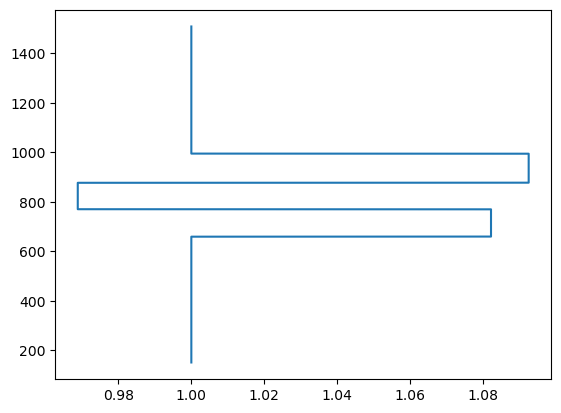

In [120]:
#calculating shift for each layer 
correction = np.ones(TWT.shape[0]) # create an empty correction the same size as the cumulative time


i=1 # starting with the first layer in the time depth pair 
for depth in timedepth['d'][1:]:
    td_time = timedepth['t'][i]-timedepth["t"][i-1] # determine the time difference between each step
    
    #determine the index for the start and end of each layer 
    ## determine where the depth is greater than the first index (+/- half a step(dz)) for the value 
    indxd0 =  np.where((DEPTH>timedepth['d'][i-1]-STEP/2) & (DEPTH<timedepth['d'][i-1]+STEP/2))
    indxd1 =  np.where((DEPTH>timedepth['d'][i]-STEP/2) & (DEPTH<timedepth['d'][i]+STEP/2))
    #print(int(indxd0[0]),int(indxd1[0]))
    
    #transforming the value to an interger 
    indxd0 = int(indxd0[0])
    indxd1 = int(indxd1[0])
    
    # determine the layer TWT from our log
    t_time = [TWT[indxd1]-TWT[indxd0]][0] # layer TWT time from log
    
    #calculate the multiplier to account for a shift in time 
    layer_corr = td_time/t_time
    #storing the layer correction that will later be used for synthetic 
    correction[indxd0:indxd1] = layer_corr
    
    #move to the next time depth layer 
    i+=1
    print(layer_corr)
    
print(correction)    
plt.plot(correction,DEPTH)
#moving average - to see changes in depth - see CheckShot-test.ipynb

(1100.0, 200.0)

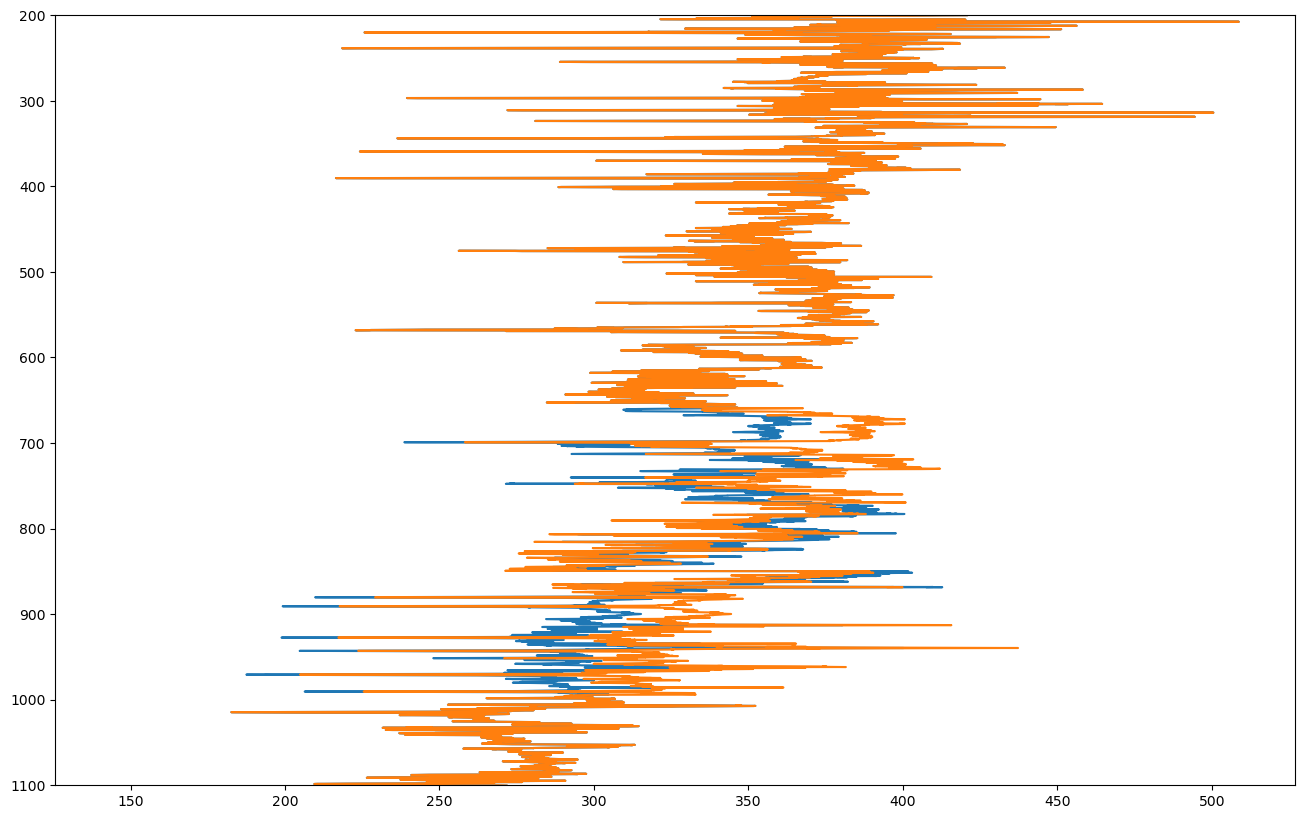

In [123]:
# Plotting the resulting difference between the original DT and the corrected DT
fig, ax = plt.subplots(figsize=(16,10))
plt.plot(DT.values,DEPTH,label="original sonic")
plt.plot(DT.values*correction,DEPTH,label="corrected sonic")
plt.legend
plt.ylim(1100,200)

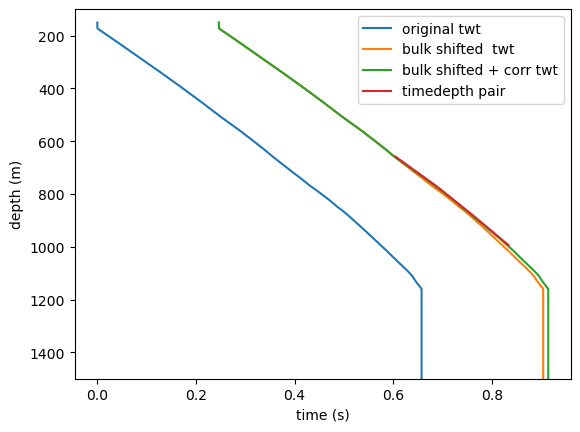

In [126]:
# applying the correction to DT and recalculating the TWT
# Time depth relationship = calculating time to each depth point and step 
DT_iterval_corr = np.nan_to_num(DT.values*correction)*2*STEP/10**6 # 2* us/m * dz / 10^6us/s = calculating time between each step, multiply by 2 and take the cumulative sum 
t_cum_corr = np.cumsum(DT_iterval_corr)
TWT_corr = t_cum_corr+log_start_time

# plotting the difference 
plt.plot(t_cum,DEPTH,label="original twt")
plt.plot(TWT,DEPTH,label="bulk shifted  twt") # time depth relationship of data 
plt.plot(TWT_corr,DEPTH,label="bulk shifted + corr twt")
plt.plot(timedepth['t'],timedepth['d'],label="timedepth pair") # time depth relationship of data 
plt.ylim(1500,100)
plt.xlabel('time (s)')
plt.ylabel('depth (m)')
plt.legend()


SystemExit: 0

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import sys
from PyQt5 import QtCore, QtWidgets
from PyQt5.QtWidgets import QMainWindow, QWidget, QLabel, QLineEdit, QFormLayout
from PyQt5.QtWidgets import QPushButton, QVBoxLayout, QHBoxLayout
from PyQt5.QtCore import QSize
 

class MainWindow(QWidget):
    def __init__(self):
        QWidget.__init__(self)
 
        self.setMinimumSize(QSize(320, 220))
        self.setWindowTitle(
            "PyQt Line Edit example (textfield) - pythonprogramminglanguage.com")
        self.controls = []
        button1 = QPushButton('add field', self)
        button1.clicked.connect(self.add_field)
        button2 = QPushButton('remove field', self)
        button2.clicked.connect(self.remove_field)
        button3 = QPushButton('OK', self)
        button3.clicked.connect(self.clickMethod)
 
        vbox = QVBoxLayout()
        formlayout = QFormLayout()
        vbox.addLayout(formlayout)
        hbox = QHBoxLayout()
        hbox.addWidget(button1)
        hbox.addWidget(button2)
        vbox.addLayout(hbox)
        vbox.addWidget(button3)
        self.setLayout(vbox)
        self.formlayout = formlayout
        self.add_field()
 
    def add_field(self):
        edit = QLineEdit(self)
        self.controls.append(edit)
        self.formlayout.addRow('Name', edit)
 
    def remove_field(self):
        if len(self.controls) > 1:
            edit = self.controls.pop()
            self.formlayout.removeRow(edit)
 
    def clickMethod(self):
        names = ', '.join(edit.text() for edit in self.controls)
        print(f'Names: {names}')
 
 
if __name__ == "__main__":
    app = QtWidgets.QApplication(sys.argv)
    mainWin = MainWindow()
    mainWin.show()
    sys.exit(app.exec_())

Names: 1, 2, 3, 4


SystemExit: 0

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
# -*- coding: utf-8 -*-

# Form implementation generated from reading ui file 'TD-DIALOG.ui'
#
# Created by: PyQt5 UI code generator 5.15.4
#
# WARNING: Any manual changes made to this file will be lost when pyuic5 is
# run again.  Do not edit this file unless you know what you are doing.


from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtWidgets import QMainWindow, QWidget, QLabel, QLineEdit, QFormLayout


class Ui_TimeDepthDialog(object):
    def __init__(self,timelist,depthlist):
        self.timelist = timelist
        self.depthlist = depthlist 
        
    
    def setupUi(self, TimeDepthDialog):
        TimeDepthDialog.setObjectName("TimeDepthDialog")
        TimeDepthDialog.resize(400, 300)
        self.gridLayout = QtWidgets.QGridLayout(TimeDepthDialog)
        self.gridLayout.setContentsMargins(10, -1, -1, -1)
        self.gridLayout.setObjectName("gridLayout")
        self.MainFrame = QtWidgets.QFrame(TimeDepthDialog)
        sizePolicy = QtWidgets.QSizePolicy(QtWidgets.QSizePolicy.MinimumExpanding, QtWidgets.QSizePolicy.MinimumExpanding)
        sizePolicy.setHorizontalStretch(0)
        sizePolicy.setVerticalStretch(0)
        sizePolicy.setHeightForWidth(self.MainFrame.sizePolicy().hasHeightForWidth())
        self.MainFrame.setSizePolicy(sizePolicy)
        self.MainFrame.setFrameShape(QtWidgets.QFrame.Box)
        self.MainFrame.setFrameShadow(QtWidgets.QFrame.Raised)
        self.MainFrame.setObjectName("MainFrame")
        self.horizontalLayout = QtWidgets.QHBoxLayout(self.MainFrame)
        self.horizontalLayout.setObjectName("horizontalLayout")
        self.Timeframe = QtWidgets.QFrame(self.MainFrame)
        self.Timeframe.setFrameShape(QtWidgets.QFrame.StyledPanel)
        self.Timeframe.setFrameShadow(QtWidgets.QFrame.Raised)
        self.Timeframe.setObjectName("Timeframe")
        self.verticalLayout_2 = QtWidgets.QVBoxLayout(self.Timeframe)
        self.verticalLayout_2.setObjectName("verticalLayout_2") #Layout for time 
        self.Timelabel = QtWidgets.QLabel(self.Timeframe)
        sizePolicy = QtWidgets.QSizePolicy(QtWidgets.QSizePolicy.Preferred, QtWidgets.QSizePolicy.Fixed)
        sizePolicy.setHorizontalStretch(0)
        sizePolicy.setVerticalStretch(0)
        sizePolicy.setHeightForWidth(self.Timelabel.sizePolicy().hasHeightForWidth())
        self.Timelabel.setSizePolicy(sizePolicy)
        self.Timelabel.setObjectName("Timelabel")
        self.verticalLayout_2.addWidget(self.Timelabel)      
        self.horizontalLayout.addWidget(self.Timeframe)
        self.DepthFrame = QtWidgets.QFrame(self.MainFrame)
        self.DepthFrame.setFrameShape(QtWidgets.QFrame.StyledPanel)
        self.DepthFrame.setFrameShadow(QtWidgets.QFrame.Raised)
        self.DepthFrame.setObjectName("DepthFrame")
        self.verticalLayout = QtWidgets.QVBoxLayout(self.DepthFrame) #Layout for Depth 
        self.verticalLayout.setObjectName("verticalLayout")
        self.DepthLabel = QtWidgets.QLabel(self.DepthFrame)
        sizePolicy = QtWidgets.QSizePolicy(QtWidgets.QSizePolicy.MinimumExpanding, QtWidgets.QSizePolicy.Fixed)
        sizePolicy.setHorizontalStretch(0)
        sizePolicy.setVerticalStretch(0)
        sizePolicy.setHeightForWidth(self.DepthLabel.sizePolicy().hasHeightForWidth())
        self.DepthLabel.setSizePolicy(sizePolicy)
        self.DepthLabel.setObjectName("DepthLabel")
        self.verticalLayout.addWidget(self.DepthLabel)
        self.horizontalLayout.addWidget(self.DepthFrame)
        self.gridLayout.addWidget(self.MainFrame, 0, 0, 1, 1)
        self.NOTElabel = QtWidgets.QLabel(TimeDepthDialog)
        self.NOTElabel.setObjectName("NOTElabel")
        self.gridLayout.addWidget(self.NOTElabel, 1, 0, 1, 1)
        self.buttonBox = QtWidgets.QDialogButtonBox(TimeDepthDialog)
        self.buttonBox.setOrientation(QtCore.Qt.Horizontal)
        self.buttonBox.setStandardButtons(QtWidgets.QDialogButtonBox.Cancel|QtWidgets.QDialogButtonBox.Ok)
        self.buttonBox.setCenterButtons(True)
        self.buttonBox.setObjectName("buttonBox")
        self.gridLayout.addWidget(self.buttonBox, 4, 0, 1, 1)
        self.AddpushButton = QtWidgets.QPushButton(TimeDepthDialog)
        self.AddpushButton.setObjectName("AddpushButton")
        self.gridLayout.addWidget(self.AddpushButton, 2, 0, 1, 1)
        self.RemovepushButton = QtWidgets.QPushButton(TimeDepthDialog)
        self.RemovepushButton.setObjectName("RemovepushButton")
        self.gridLayout.addWidget(self.RemovepushButton, 3, 0, 1, 1)

        self.retranslateUi(TimeDepthDialog)
        self.buttonBox.accepted.connect(TimeDepthDialog.accept)
        self.buttonBox.rejected.connect(TimeDepthDialog.reject)
        QtCore.QMetaObject.connectSlotsByName(TimeDepthDialog)
        
        # Controls for creating and removing rows
        self.control_time = []
        self.control_depth = [] 
        #add the first set of field 
        #self.add_field()
        #loading last list iff exist
        self.load_last(timelist,depthlist)
    
        #connection for each button 
        self.AddpushButton.clicked.connect(self.add_field)
        self.RemovepushButton.clicked.connect(self.remove_field)
        
        #temporary connection to Ok and cancel buttons 
        self.buttonBox.accepted.connect(self.get_Inputs)
        

    
    #method to load previously entered timelist and depth list 
    def load_last(self,timelist,depthlist): 
        # if there is data to load - load data
        if timelist != None:
            # for each item in the time list/depth list 
            for i in range(len(timelist)):
                # add it to each of the respected field 
                #self.add_field().addtext(timelist[i],depthlist[i])        
                #adding a row of time 
                timeedit = QLineEdit()
                timeedit.setText(str(timelist[i]))
                self.control_time.append(timeedit)
                self.verticalLayout_2.addWidget(timeedit)
                #adding a row of depth 
                depthedit = QLineEdit()
                depthedit.setText(str(depthlist[i]))
                self.control_depth.append(depthedit)
                self.verticalLayout.addWidget(depthedit)
                
        # otherwise, create an instance of the first field 
        else:
            self.add_field()
                
                
            
    
    # method to remove fields
    def remove_field(self):
        if len(self.control_time) >1:
            #removing the time row
            timeedit = self.control_time.pop()
            self.verticalLayout_2.removeWidget(timeedit)
            #removing the depth row
            depthedit = self.control_depth.pop()
            self.verticalLayout.removeWidget(depthedit)

    
    #method to add fields 
    def add_field(self):
        #adding a row of time 
        timeedit = QLineEdit()
        self.control_time.append(timeedit)
        self.verticalLayout_2.addWidget(timeedit)
        #adding a row of depth 
        depthedit = QLineEdit()
        self.control_depth.append(depthedit)
        self.verticalLayout.addWidget(depthedit)
        
        #method to add previous data 
            
        
        
    def get_Inputs(self):
        time = ', '.join(timeedit.text() for timeedit in self.control_time)#', '.join(edit.text() for edit in self.controls)
        depth = ', '.join(depthedit.text() for depthedit in self.control_depth)
        print(time)
        print(depth)
    
        

    def retranslateUi(self, TimeDepthDialog):
        _translate = QtCore.QCoreApplication.translate
        TimeDepthDialog.setWindowTitle(_translate("TimeDepthDialog", "TimeDepthPair"))
        self.Timelabel.setText(_translate("TimeDepthDialog", "Time (s): "))
        #self.TimelineEdit.setPlaceholderText(_translate("TimeDepthDialog", "0.6"))
        self.DepthLabel.setText(_translate("TimeDepthDialog", "Depth - SubSea (m):"))
        #self.DepthlineEdit.setPlaceholderText(_translate("TimeDepthDialog", "200"))
        self.NOTElabel.setText(_translate("TimeDepthDialog", "NOTE: AT LEAST TWO PAIRS ARE NEEDED"))
        self.AddpushButton.setText(_translate("TimeDepthDialog", "Add Row"))
        self.RemovepushButton.setText(_translate("TimeDepthDialog", "Remove Row"))


if __name__ == "__main__":
    import sys
    app = QtWidgets.QApplication(sys.argv)
    TimeDepthDialog = QtWidgets.QDialog()
    ui = Ui_TimeDepthDialog(timelist,depthlist)
    ui.setupUi(TimeDepthDialog)
    TimeDepthDialog.show()
    sys.exit(app.exec_())
    

#data = Ui_TimeDepthDialog(timelist,depthlist)
    
"""
For accepting values after using function 

def ShowGroupROIFunction(self):
    dialog = SGROIWidget_ui.Ui_ShowGroupWidget()
    if dialog.exec_():
        print(dialog.roiGroups)


"""


1, 2
3, 4


SystemExit: 0

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
    def gensynaction(self,havesonic1,havedensity1,well1,well1df,havesonic2,havedensity2,well2,well2df):
        #determining which well will have the 
        well_sel = int(self.wavelet_well_sel_comboBox.currentText())
        dt = float(self.sample_rate_comboBox.currentText())
        t_max = float(self.max_time_comboBox.currentText())
        t =  np.arange(0,t_max,dt)
        w_type = self.wave_type_comboBox.currentText()
        wave_len = float(self.wave_length_comboBox.currentText())/1000 #(s)
        
        #clearing the current graphs of data: 
        if well_sel == 1: 
            self.w1syn.clear()
            self.wavelet_graph.clear()
        else: # well selected is 2 
            self.w2syn.clear()
            self.wavelet_graph_2.clear()

        # Note: For data that only required 1 frequency, we are using LPF_slider
        
        if well_sel == 1: 
            AI = well1df.AI.values
            AI = np.nan_to_num(AI)
            RC = well1df.Rc.values
            RC = np.nan_to_num(RC)
            TWT = well1df['TWT'].values
        else: 
            AI = well2df.AI.values
            AI = np.nan_to_num(AI)
            RC = well2df.Rc.values
            RC = np.nan_to_num(RC)
            TWT = well2df['TWT'].values
        #### Reflection Coefficient and Acoustic Impedance interpolation ############# incorrect acoustic impedance interpolation 
        """
        7. Resampling AI into time domain via interpolation
        """
        if well_sel == 1: 
            AI_tdom = np.interp(x=t,xp=well1df['TWT'].values,fp=AI)
        else: 
            AI_tdom = np.interp(x=t,xp=well2df['TWT'].values,fp=AI)

        """
        8. Calculation of Reflection Coefficient in time domain 
        """
        
        #reflection coefficient in time domain 
        # again Rc calulation but in reampled time domain
        Rc_tdom = []
        for i in range(len(AI_tdom)-1):
            Rc_tdom.append((AI_tdom[i+1]-AI_tdom[i])/(AI_tdom[i]+AI_tdom[i+1]))
        # to adjust vector size copy the last element to the tail
        Rc_tdom.append(Rc_tdom[-1])
        #print("Rc_tdom",Rc_tdom)
        
        
        #dataframe for plotting items in dataframe 
        if well_sel == 1: 
            if self.well1df_tdom.empty :
                self.comboBox_Track1.addItems(['AI_tdom','Rc_tdom'])
                self.comboBox_Track2.addItems(['AI_tdom','Rc_tdom'])
                self.comboBox_Track3.addItems(['AI_tdom','Rc_tdom'])
            tdom_data1 = {'AI_tdom':AI_tdom,'Rc_tdom':Rc_tdom}
            well1df_tdom = pd.DataFrame(data = tdom_data1,index = t)
            self.well1df_tdom = well1df_tdom
            
        else:
            if self.well2df_tdom.empty: 
                self.comboBox_Track1_well2.addItems(['AI_tdom','Rc_tdom'])
                self.comboBox_Track2_well2.addItems(['AI_tdom','Rc_tdom'])
                self.comboBox_Track3_well2.addItems(['AI_tdom','Rc_tdom'])
            tdom_data2 = {'AI_tdom':AI_tdom,'Rc_tdom':Rc_tdom}
            well2df_tdom = pd.DataFrame(data =tdom_data2,index=t)
            self.well2df_tdom = well2df_tdom
       
        """
        9. Acquire Wavelet 
        """
        #wavelet data 
        print(w_type)
        
        #can create a function to reduce code 
        if w_type == "Ricker": # only need 1 frequency 
            freq = float(self.LPF_slider.value())
            wavelet, wavelet_time = bg.filters.ricker(wave_len,dt,freq)#

        elif w_type == "Ormsby":
            LCF = float(self.LCF_slider.value())
            LPF = float(self.LPF_slider.value())
            HPF = float(self.HPF_slider.value())
            HCF = float(self.HCF_slider.value())
            # need warning sign that LCF < LPF < HPF < HCF 
            freq = [LCF,LPF,HPF,HCF]
            wavelet, wavelet_time = bg.filters.ormsby(wave_len, dt, f=freq)
        elif w_type == "Berlage":
            freq = float(self.LPF_slider.value())
            wavelet, wavelet_time = bg.filters.berlage(wave_len, dt, freq) 
        else: #Generalized
            freq = float(self.LPF_slider.value())
            wavelet, wavelet_time = bg.filters.generalized(wave_len, dt, freq)
        
        
        #phase rotation of wavelet via Hilbert Transform 
        rotate_phase = float(self.Phase_slider.value()) #degrees 
        if rotate_phase != 0:
            wavelet = bg.filters.filters.rotate_phase(wavelet,rotate_phase,degrees=True)

        #plotting of wavelet
        trackplot = pg.PlotCurveItem(wavelet,wavelet_time,connect='finite',pen=(255, 0, 0))
        #clearing the current graphs of data: 
        if well_sel == 1: 
            self.wavelet_graph.addItem(trackplot)
        else: 
            self.wavelet_graph_2.addItem(trackplot)
        
        
        """
        10. synthetic convolution via numpy convolution
        """
        
        #convolution of data                
        synth = np.convolve(np.nan_to_num(Rc_tdom),wavelet, mode = 'same')  
        synth = np.nan_to_num(synth)
        synth = np.asarray(synth)
        
        #print(synth)
        #amplitude multiplier: 1.0-10.0x 
        multiplier = float(self.Amp_slider.value())/10
        synth = multiplier*synth
        #print(synth)

        #Adding curve fill ability 
        synth_pos = np.where(synth < 0, 0, synth) # positive synthetic only
        syn_co = synth * 0 # synthetic curve ]
        synth_pos_curve = pg.PlotCurveItem(x=synth_pos[0:len(t)], y=t[0:], pen='b') # creating a curve with positive only 
        syn_co_curve = pg.PlotCurveItem(x=syn_co[0:len(t)], y=t[0:], pen=[0, 0, 0, 125]) # creating the constant curve 
        syn_fill = pg.FillBetweenItem(synth_pos_curve, syn_co_curve, brush=[150, 150, 150]) #creating the fill curve 
        
        
        #creating a trackplot to add the curvefill 
        pen = pg.mkPen(color=(255, 0, 0))
        trackplot = pg.PlotCurveItem(synth[0:len(t)],t,connect='finite',pen=(150, 150, 150)) 
        
        #amplitude multiplier: 1-10x 
        
        
        if well_sel == 1: 
            self.w1syn.addItem(syn_fill)
            self.w1syn.addItem(trackplot)
            self.w1syn.invertY(True)
            self.w1syn.showGrid(x=True,y=True)
            self.w1syn.setTitle(title = "W1 Synth: "+w_type)
            print('plotted 1') 
            #print(freq,wave_len)
        else: 
            
            self.w2syn.addItem(syn_fill)
            self.w2syn.addItem(trackplot)
            self.w2syn.invertY(True)
            self.w2syn.showGrid(x=True,y=True)
            self.w2syn.setTitle(title = "W2 Synth: "+w_type)
            print('plotted 2') 